In [62]:
import torch
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import Counter
from wordcloud import WordCloud

In [63]:
# Load dữ liệu đã xử lý
PROCESSED_DATA_FILE = "../data/processed/processed_data.pt"
data = torch.load(PROCESSED_DATA_FILE)

# Kiểm tra số lượng mẫu trong tập train, val, test

In [64]:
metadata = data["metadata"]
print(
    f"Tổng số mẫu: Train={metadata['num_train']}, Val={metadata['num_val']}, Test={metadata['num_test']}"
)
print(f"Số lượng câu trả lời: {metadata['num_answers']}")
print(f"Số lượng ký tự trong vocab: {metadata['num_vocab']}\n")

Tổng số mẫu: Train=27304, Val=3424, Test=3588
Số lượng câu trả lời: 1951
Số lượng ký tự trong vocab: 88



## Kiểm tra vocab

In [65]:
vocab = data["vocab"]
print(f"Ví dụ 20 ký tự đầu tiên trong vocab: {list(vocab.keys())[:20]}")

Ví dụ 20 ký tự đầu tiên trong vocab: ['<PAD>', '<UNK>', 'Đ', 'â', 'y', ' ', 'l', 'à', 'q', 'u', 'ả', 'g', 'ì', '?', 'C', 'ó', 'b', 'a', 'o', 'n']


## Kiểm tra từ điển câu trả lời

In [66]:
answer_dict = data["answer_dict"]
print(f"Ví dụ 20 câu trả lời đầu tiên: {list(answer_dict.keys())[:20]}")

Ví dụ 20 câu trả lời đầu tiên: ['<UNK>', 'hạt dẻ', 'quả dẻ', 'trái dẻ', 'dẻ', 'quả hạt dẻ', 'không rõ', 'nâu', 'màu nâu', 'nâu đỏ', 'đỏ nâu', 'màu hạt dẻ', 'bốn', '4', 'bốn quả', 'màu nâu đỏ', 'trên vải', 'vải', 'trên mặt vải', 'mặt vải']


## Biểu đồ phân bố số lượng ảnh trong train/val/test

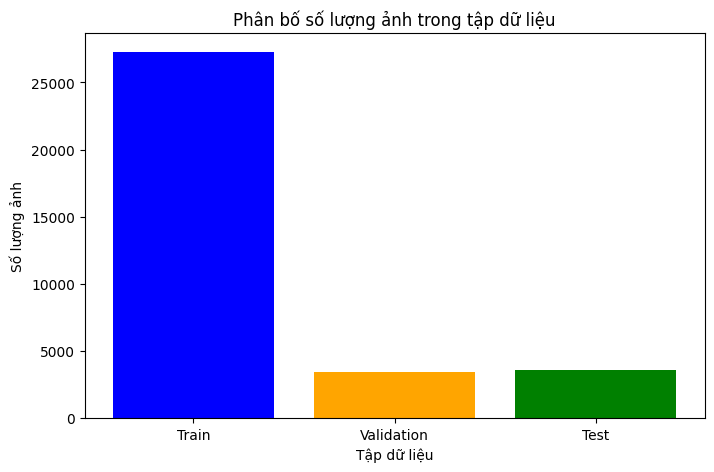

In [67]:
plt.figure(figsize=(8, 5))
plt.bar(
    ["Train", "Validation", "Test"],
    [metadata["num_train"], metadata["num_val"], metadata["num_test"]],
    color=["blue", "orange", "green"],
)
plt.xlabel("Tập dữ liệu")
plt.ylabel("Số lượng ảnh")
plt.title("Phân bố số lượng ảnh trong tập dữ liệu")
plt.show()

## Trực quan hóa dữ liệu mẫu từ tập train

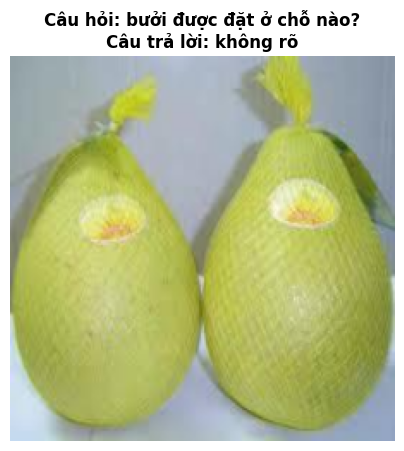


Mẫu 1:
- Câu hỏi gốc     : bưởi được đặt ở chỗ nào?
- Tensor câu hỏi  : [16, 34, 31, 21, 5, 29, 34, 35, 27, 5, 29, 30, 24, 5, 31, 5, 27, 20, 40, 5, 19, 7, 18, 13, 0, 0, 0, 0, 0, 0]
- Câu trả lời gốc : không rõ
- ID câu trả lời  : 6



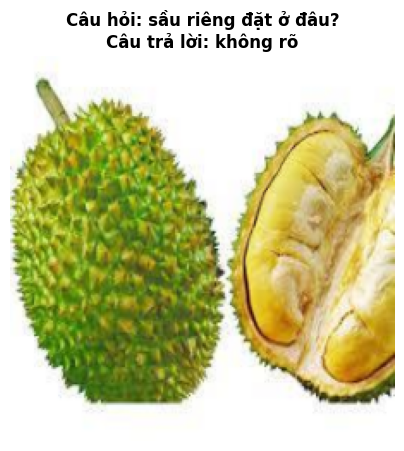


Mẫu 2:
- Câu hỏi gốc     : sầu riêng đặt ở đâu?
- Tensor câu hỏi  : [37, 55, 9, 5, 43, 21, 22, 19, 11, 5, 29, 30, 24, 5, 31, 5, 29, 3, 9, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
- Câu trả lời gốc : không rõ
- ID câu trả lời  : 6



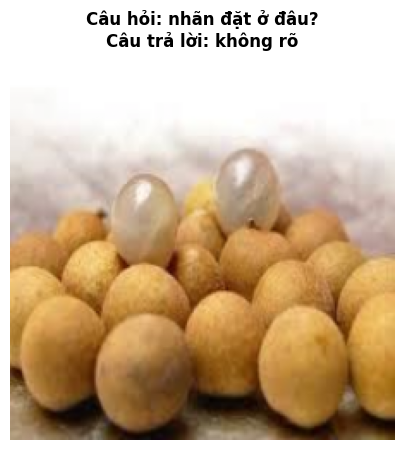


Mẫu 3:
- Câu hỏi gốc     : nhãn đặt ở đâu?
- Tensor câu hỏi  : [19, 20, 54, 19, 5, 29, 30, 24, 5, 31, 5, 29, 3, 9, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
- Câu trả lời gốc : không rõ
- ID câu trả lời  : 6



In [68]:
random_samples = random.sample(data["train"], 3) 

for i, sample in enumerate(random_samples):
    img_tensor = sample["image"]

    # Bỏ chuẩn hóa (unnormalize)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_tensor = img_tensor * std + mean
    img_tensor = torch.clamp(img_tensor, 0, 1)

    # Chuyển tensor thành ảnh numpy
    img_numpy = img_tensor.permute(1, 2, 0).numpy()

    # Giải mã câu hỏi từ tensor (Bỏ <PAD>)
    question_tensor = sample["question"]
    question_text = "".join(
        [
            list(vocab.keys())[list(vocab.values()).index(i)]
            for i in question_tensor.tolist()
            if i in vocab.values() and i != vocab["<PAD>"]
        ]
    )

    # Giải mã câu trả lời từ ID
    answer_id = sample["answer_id"].item()
    answer_text = list(answer_dict.keys())[list(answer_dict.values()).index(answer_id)]

    # Hiển thị ảnh cùng thông tin chi tiết
    plt.figure(figsize=(5, 5))
    plt.imshow(img_numpy)
    plt.axis("off")
    plt.title(
        f"Câu hỏi: {question_text}\nCâu trả lời: {answer_text}",
        fontsize=12,
        fontweight="bold",
    )
    plt.show()

    # Hiển thị thông tin chi tiết
    print(f"\nMẫu {i+1}:")
    print(f"- Câu hỏi gốc     : {question_text}")
    print(f"- Tensor câu hỏi  : {question_tensor.tolist()}")
    print(f"- Câu trả lời gốc : {answer_text}")
    print(f"- ID câu trả lời  : {answer_id}\n")

## Biểu đồ phân bố độ dài câu hỏi

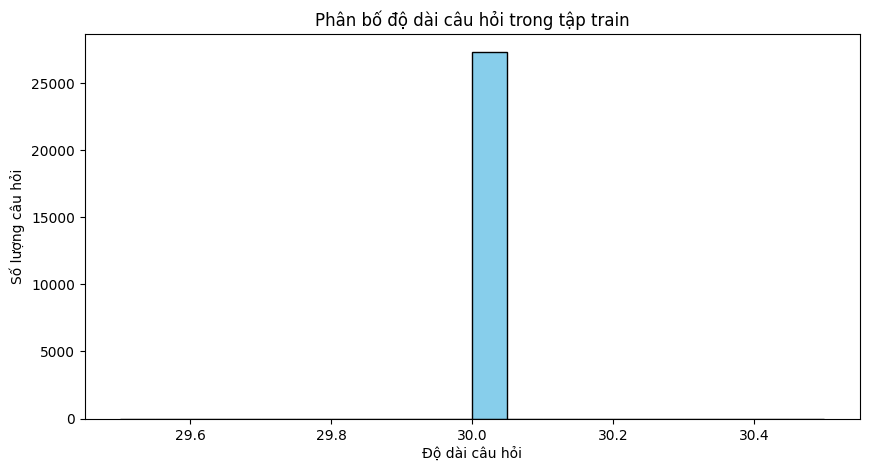

In [69]:
question_lengths = [len(sample["question"]) for sample in data["train"]]

plt.figure(figsize=(10, 5))
plt.hist(question_lengths, bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Độ dài câu hỏi")
plt.ylabel("Số lượng câu hỏi")
plt.title("Phân bố độ dài câu hỏi trong tập train")
plt.show()

## Biểu đồ top câu hỏi phổ biến

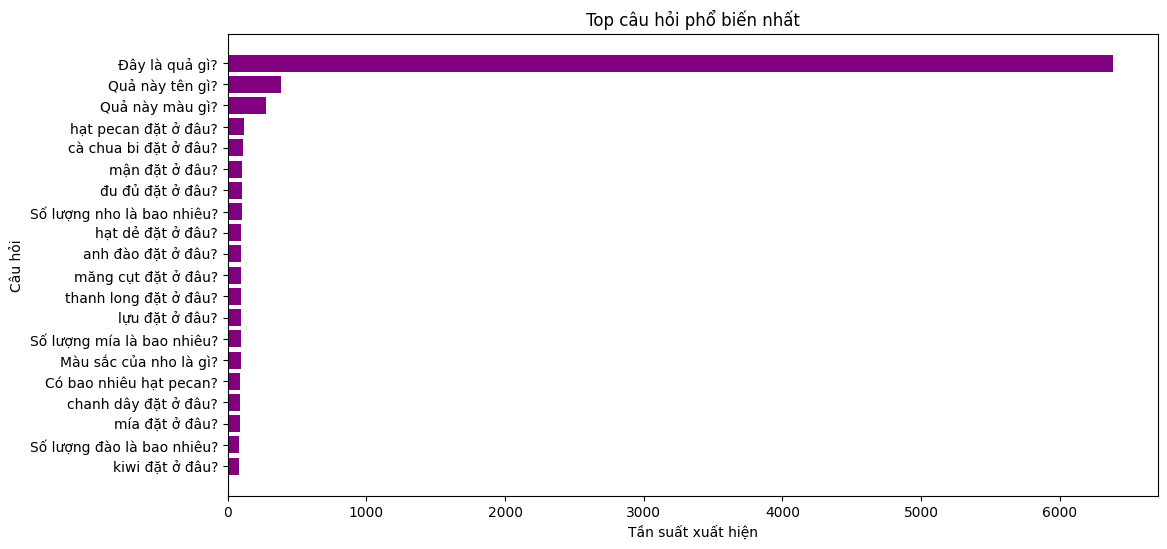

In [70]:
question_texts = [
    "".join(
        [
            list(vocab.keys())[list(vocab.values()).index(i)]
            for i in sample["question"].tolist()
            if i in vocab.values() and i != vocab["<PAD>"]
        ]
    )
    for sample in data["train"]
]

question_counts = Counter(question_texts)
most_common_questions = dict(question_counts.most_common(20))

plt.figure(figsize=(12, 6))
plt.barh(
    list(most_common_questions.keys()),
    list(most_common_questions.values()),
    color="purple",
)
plt.xlabel("Tần suất xuất hiện")
plt.ylabel("Câu hỏi")
plt.title("Top câu hỏi phổ biến nhất")
plt.gca().invert_yaxis()  # Đảo ngược trục Y để câu hỏi xuất hiện trên xuống dưới
plt.show()

## Biểu đồ số lượng câu trả lời phổ biến

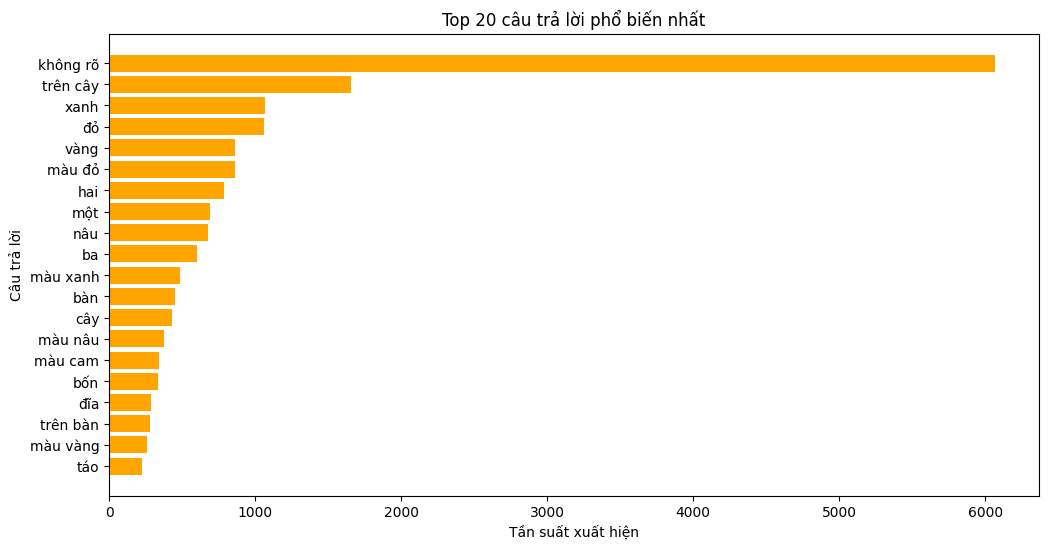

In [71]:
answer_counts = Counter(
    [
        list(answer_dict.keys())[
            list(answer_dict.values()).index(sample["answer_id"].item())
        ]
        for sample in data["train"]
    ]
)
most_common_answers = dict(
    answer_counts.most_common(20)
)  # 20 câu trả lời phổ biến nhất

plt.figure(figsize=(12, 6))
plt.barh(
    list(most_common_answers.keys()), list(most_common_answers.values()), color="orange"
)
plt.xlabel("Tần suất xuất hiện")
plt.ylabel("Câu trả lời")
plt.title("Top 20 câu trả lời phổ biến nhất")
plt.gca().invert_yaxis()  # Đảo ngược trục Y để câu trả lời xuất hiện trên xuống dưới
plt.show()

## WordCloud trực quan vocab

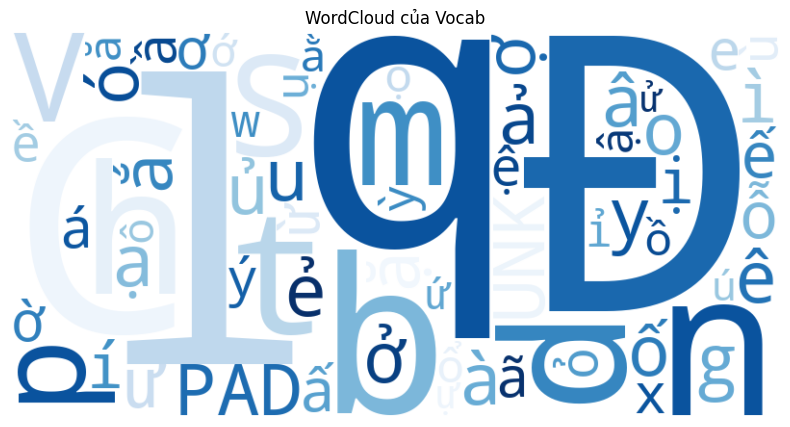

In [72]:
wordcloud_text = " ".join(vocab.keys())

wordcloud = WordCloud(
    width=800, height=400, background_color="white", colormap="Blues"
).generate(wordcloud_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud của Vocab")
plt.show()

## WordCloud trực quan câu hỏi

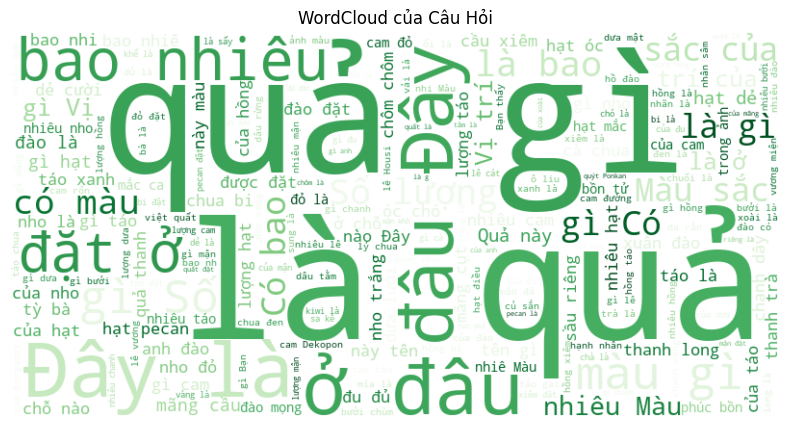

In [73]:
question_words = " ".join(question_texts)

wordcloud_questions = WordCloud(
    width=800, height=400, background_color="white", colormap="Greens"
).generate(question_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_questions, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud của Câu Hỏi")
plt.show()

##  WordCloud trực quan câu trả lời

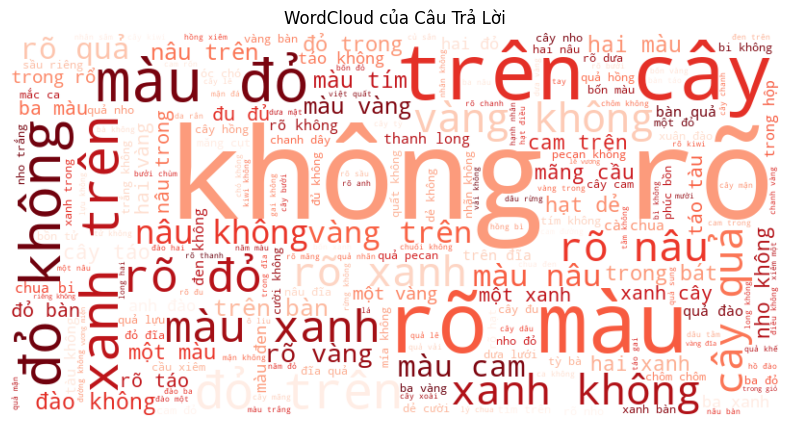

In [74]:
answer_words = " ".join(
    [
        list(answer_dict.keys())[
            list(answer_dict.values()).index(sample["answer_id"].item())
        ]
        for sample in data["train"]
    ]
)

wordcloud_answers = WordCloud(
    width=800, height=400, background_color="white", colormap="Reds"
).generate(answer_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_answers, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud của Câu Trả Lời")
plt.show()